**Summary from exposure analysis:** 
- ARK has statistically significant betas to SPY, Treasuries and commodities
- ARK performs better worse in market downturns
- With the greatest statistical conviction,  we can say that the mean returns of ARK differs when SPY has cumulative returns of +/- 10% in a 50-day window 
- Large healthcare exposure

**Todo: **
- Calibrate option hedging strategy, buying 10% in the money puts with T=50 days expiry and sell 10% in the money calls with T=50 days expiry
- Investigate healthcare ETF's 
- Invetsigate tail risks that may have not materialized yet



In [245]:
import pandas as pd
import sys
import matplotlib.pyplot as plt
import yfinance as yf
import statsmodels.api as sm


In [246]:
port_weights = pd.read_csv("./data/weights.csv", parse_dates=True)
etf_holdings = pd.read_csv("./data/holdings.csv", parse_dates=True)
macro_retz = pd.read_csv("./data/macro_retz.csv", parse_dates=True)
synth_retz = pd.read_csv("./data/synth_ark_rets.csv", parse_dates=True)
cum_retz = pd.read_csv("./data/cum_retz.csv", parse_dates=True)
ark = pd.read_csv("./data/ark.csv", parse_dates=True)

**Load in and visualize the up-swings and down-swings which we are trying to hedge against**

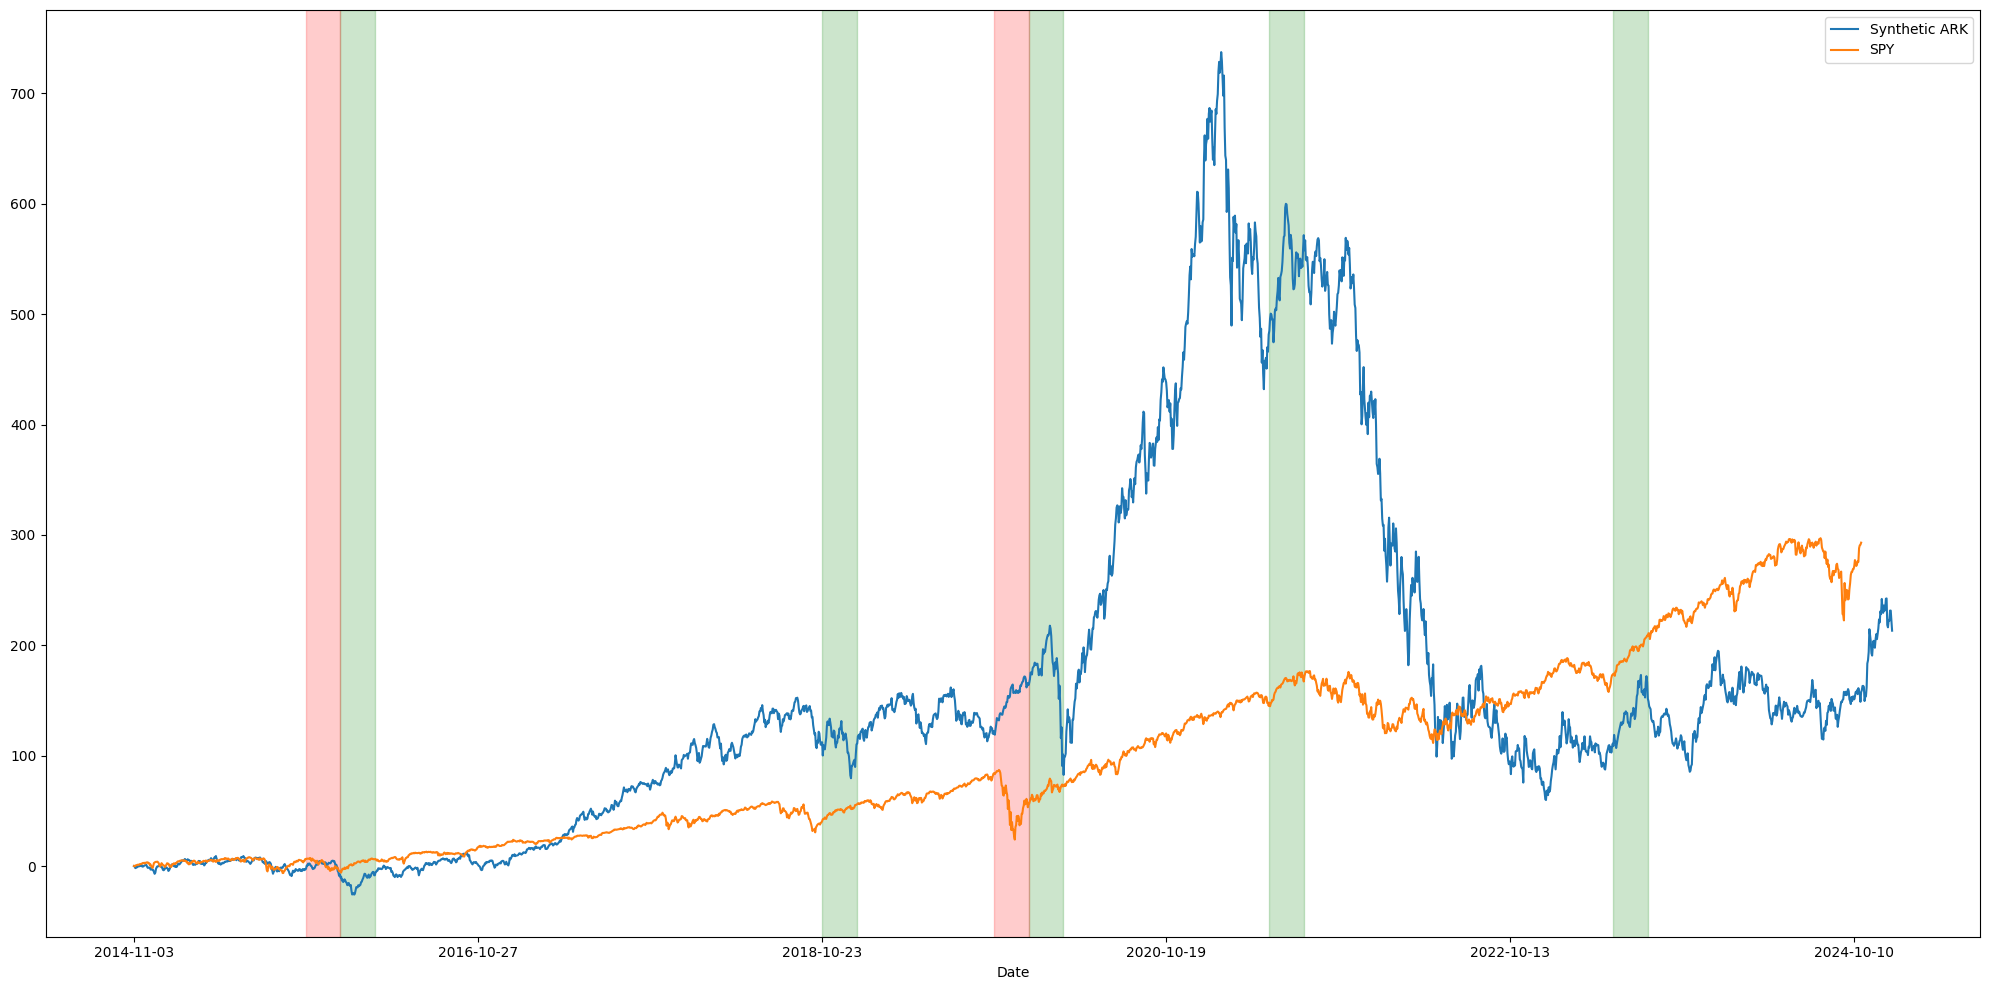

In [247]:
from helper_functions import label_market_swings 

macro_retz = label_market_swings(macro_retz, window = 50)

plot_df = pd.concat([ark, macro_retz['SPY'], macro_retz['upswing'], macro_retz['downswing']], axis = 1)
plot_df.set_index('Date', inplace = True)
plot_df.columns = ['ARK', 'SPY', 'upswing', 'downswing']
plot_df['ARK'] = ((1 + plot_df['ARK']).cumprod() - 1) * 100
plot_df['SPY'] = ((1 + plot_df['SPY']).cumprod() - 1) * 100

fig, ax = plt.subplots(figsize = (20, 10))
plot_df['ARK'].plot(ax = ax, label = 'Synthetic ARK')
plot_df['SPY'].plot(ax = ax, label = 'SPY')
ymin, ymax = ax.get_ylim()

in_upswing = False
for i in range(len(plot_df)):
    if plot_df['upswing'].iloc[i] == 1 and not in_upswing:
        ups_start = i
        in_upswing = True
    elif plot_df["upswing"].iloc[i] == 0 and in_upswing:
        ups_end = i
        ax.axvspan(ups_start, ups_end, color='green', alpha=0.2)
        in_upswing = False

in_downswing = False
for i in range(len(plot_df)):
    if plot_df["downswing"].iloc[i] == 1 and not in_downswing:
        down_start = i
        in_downswing = True
    elif plot_df["downswing"].iloc[i] == 0 and in_downswing:
        down_end = i
        ax.axvspan(down_start, down_end, color='red', alpha=0.2)
        in_downswing = False
plt.legend()
plt.tight_layout()



**LOAD AND CLEAN OPTION DATA**

In [248]:
option_data = pd.read_csv("./data/options.csv", parse_dates = True)
option_data['date'] = pd.to_datetime(option_data['date'])
option_data.set_index('date', inplace=True)
columns_to_keep = ['days', 'strike_price', 'cp_flag',  'premium',  'delta', 'gamma', 'vega', 'theta']
option_data = option_data[columns_to_keep]
spy_price = pd.read_csv("./data/spy_prices.csv", parse_dates=True)
spy_price['Date'] = pd.to_datetime(spy_price['Date'], utc=True)
spy_price['Date'] = spy_price['Date'].dt.normalize().dt.tz_localize(None)
spy_price.set_index('Date', inplace=True)
option_data.index = option_data.index.normalize()
option_data = option_data.join(spy_price)
option_data.rename(columns={'Close':'SPY'}, inplace=True)
option_data

,days,strike_price,cp_flag,premium,delta,gamma,vega,theta,SPY
2014-01-02,10,182.927456,C,1.419628,0.503879,0.112071,12.079142,-26.031128,NaN
2014-01-02,30,182.949524,C,2.545279,0.506954,0.062499,20.919505,-15.652547,NaN
2014-01-02,60,182.990267,C,3.723820,0.510174,0.042709,29.579539,-11.528563,NaN
2014-01-02,91,182.207795,C,5.071038,0.538627,0.033943,35.665870,-10.137282,NaN
2014-01-02,122,182.251810,C,5.849060,0.530419,0.028933,41.513468,-9.208565,NaN
...,...,...,...,...,...,...,...,...,...
2023-08-31,182,459.728682,P,19.151897,-0.541761,0.011287,120.287593,-7.297156,439.970764
2023-08-31,273,464.974639,P,25.284541,-0.553933,0.009303,142.822738,-4.408136,439.970764
2023-08-31,365,470.293355,P,30.665202,-0.569648,0.008479,160.245994,-2.718230,439.970764
2023-08-31,547,479.823396,P,40.379025,-0.589740,0.007348,189.943388,-0.864316,439.970764


Given we are hedging against market downturns of 10% in the next 50 days, at each timestep, keep option with min ||DTE - 50||^2 and min ||moneyness - 10||^2 for put and call. The code below filters all options and suggets one put and one call which fit hedging criteria for every time step

In [249]:

option_data = option_data.dropna()
def compute_moneyness(row):
    if row['cp_flag'] == 'C':
        return (row['SPY'] / row['strike_price']) - 1
    elif row['cp_flag'] == 'P':
        return (row['strike_price'] / row['SPY']) - 1
    else:
        return None

option_data['moneyness'] = option_data.apply(compute_moneyness, axis=1)

target_dte = 50 
target_moneyness = 0.10

option_data['dte_diff'] = (option_data['days'] - target_dte).abs()
option_data['moneyness_diff'] = (option_data['moneyness'] - target_moneyness).diff()
option_data['trade_score'] = option_data['dte_diff'] + 10 * option_data['moneyness_diff']

option_data_sorted = option_data.sort_values(['trade_score'])

option_data_sorted = option_data_sorted.copy()
option_data_sorted['datetime'] = option_data_sorted.index 




best_options = (
    option_data_sorted
    .groupby(['datetime', 'cp_flag'], sort=False)
    .first()
    .reset_index()
)

best_options.set_index('datetime', inplace=True)

best_options.sort_index(inplace=True)
best_options


/var/folders/tn/fw1cv27j6bsf_4j55pn72ls80000gn/T/ipykernel_61745/1463186617.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  option_data['moneyness'] = option_data.apply(compute_moneyness, axis=1)
/var/folders/tn/fw1cv27j6bsf_4j55pn72ls80000gn/T/ipykernel_61745/1463186617.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  option_data['dte_diff'] = (option_data['days'] - target_dte).abs()
/var/folders/tn/fw1cv27j6bsf_4j55pn72ls80000gn/T/ipykernel_61745/1463186617.py:16: SettingWithCopyWarning: 
A value

,cp_flag,days,strike_price,premium,delta,gamma,vega,theta,SPY,moneyness,dte_diff,moneyness_diff,trade_score
datetime,,,,,,,,,,,,,
2014-10-31,P,60,200.593303,4.260579,-0.486980,0.036959,32.425094,-12.740187,167.990204,0.194077,10,-0.006511,9.934886
2014-10-31,C,60,200.593303,4.757017,0.550438,0.037766,31.815263,-14.186466,167.990204,-0.162533,10,0.004542,10.045420
2014-11-03,P,60,200.657940,4.434677,-0.486228,0.035463,32.435418,-13.404036,168.081848,0.193811,10,-0.006478,9.935217
2014-11-03,C,60,200.657940,4.782514,0.549122,0.037589,31.812122,-14.387708,168.081848,-0.162346,10,0.004521,10.045210
2014-11-04,C,60,200.004212,4.844026,0.547860,0.037021,31.838187,-14.840399,167.498688,-0.162524,10,0.004555,10.045548
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-29,P,60,451.428871,9.646016,-0.520862,0.019053,70.807894,-18.298881,438.808228,0.028761,10,0.004492,10.044920
2023-08-30,P,60,453.297548,9.332790,-0.523396,0.019891,70.925856,-17.312311,440.615570,0.028782,10,0.004495,10.044951
2023-08-30,C,60,453.297548,9.135186,0.508331,0.017285,72.667762,-39.250269,440.615570,-0.027977,10,-0.004266,9.957342


Need to compute hedge ratios, rolling regression against some macro-factors to get a time-series of returns. 

In [250]:
macro_retz = macro_retz.drop(columns=['upswing', 'downswing'])
macro_retz.set_index('Date', inplace=True)



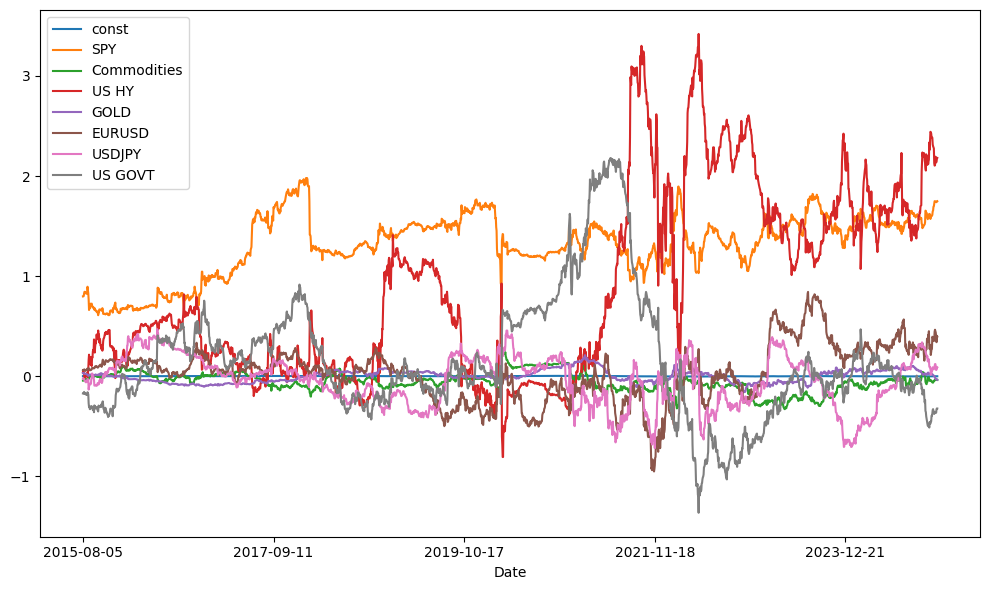

In [252]:
def rolling_reg(response: pd.Series, regressors: pd.DataFrame, window: int, plot:bool = False)->pd.DataFrame: 
    """
    Takes in a series of returns, and a dataframe of regressors and compute the rolling beta's for each factor in regressors DF

    plot = True will produce a plot of the rolling betas 
    """
    betas = []
    for i in range(window, len(response)): 
        y_window = response.iloc[i - window: i]
        x_window = regressors.iloc[i-window: i]

        X = sm.add_constant(x_window)

        model = sm.OLS(y_window, X).fit()

        betas.append(model.params)
    
    betas_df = pd.DataFrame(betas, index=response.index[window:])

    if plot: 
        fig, ax = plt.subplots(figsize=(10,6))
        betas_df.plot(ax=ax)
        plt.legend()
        plt.tight_layout()
        plt.show()
        
    return betas_df

ark.set_index('Date', inplace=True)
reg_df = ark.join(macro_retz, how = 'inner')
y = reg_df['Ark'].copy()
X = reg_df.drop(columns=['Ark'])
betas_df = rolling_reg(y, X, window=180, plot=True)

In [268]:
betas_df.index = pd.to_datetime(betas_df.index).normalize()
ark.index = pd.to_datetime(ark.index).normalize()
best_options['Ark Price'] = ark['Ark']
best_options['Beta'] = betas_df['SPY']
best_options= best_options.dropna()
best_options

,cp_flag,days,strike_price,premium,delta,gamma,vega,theta,SPY,moneyness,dte_diff,moneyness_diff,trade_score,Beta,Ark Price
datetime,,,,,,,,,,,,,,,
2015-08-05,P,60,209.061267,4.178960,-0.487561,0.037681,33.791284,-12.628661,177.607025,0.177100,10,-0.005904,9.940958,0.796558,0.002375
2015-08-05,C,60,209.061267,4.461774,0.545588,0.040179,32.692047,-13.616194,177.607025,-0.150455,10,0.004240,10.042400,0.796558,0.002375
2015-08-06,P,60,207.426502,4.415270,-0.487608,0.035765,33.520500,-13.097385,176.152893,0.177537,10,-0.005471,9.945287,0.796936,-0.014218
2015-08-06,C,60,207.426502,4.756847,0.542195,0.037288,33.039939,-14.911408,176.152893,-0.150770,10,0.003928,10.039276,0.796936,-0.014218
2015-08-07,P,60,206.769234,4.467895,-0.486143,0.035152,33.417229,-14.013603,175.814651,0.176064,10,-0.006092,9.939079,0.799775,-0.001106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-29,P,60,451.428871,9.646016,-0.520862,0.019053,70.807894,-18.298881,438.808228,0.028761,10,0.004492,10.044920,1.781789,0.054284
2023-08-30,P,60,453.297548,9.332790,-0.523396,0.019891,70.925856,-17.312311,440.615570,0.028782,10,0.004495,10.044951,1.813487,0.006927
2023-08-30,C,60,453.297548,9.135186,0.508331,0.017285,72.667762,-39.250269,440.615570,-0.027977,10,-0.004266,9.957342,1.813487,0.006927


,Ark
Date,
2014-11-03,0.000000
2014-11-04,-0.005888
2014-11-05,-0.012833
2014-11-06,0.007000
2014-11-07,-0.000993
...,...
2024-12-23,-0.002694
2024-12-24,0.029034
2024-12-26,0.000000
